In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing,
import os

**Import all necessary libraries**

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, UpSampling2D, Concatenate, GlobalAveragePooling2D, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

**Create the masks from the given JSON files**

In [3]:
# Data Generator
class BrainTumorDataset(Sequence):
    def __init__(self, json_file, root_dir, batch_size=4, image_size=(256, 256)):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.image_size = image_size

        with open(json_file) as f:
            self.data = json.load(f)

        self.image_keys = list(self.data.keys())

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def __getitem__(self, idx):
        batch_keys = self.image_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for key in batch_keys:
            image_info = self.data[key]
            file_name = image_info['filename']
            file_path = os.path.join(self.root_dir, file_name)

            image = load_img(file_path, target_size=self.image_size)
            image = img_to_array(image) / 255.0

            mask = np.zeros(self.image_size, dtype=np.uint8)

            for region in image_info['regions']:
                shape_attributes = region['shape_attributes']
                if shape_attributes['name'] == 'polygon':
                    points_x = shape_attributes['all_points_x']
                    points_y = shape_attributes['all_points_y']
                    points = np.array(list(zip(points_x, points_y)), dtype=np.int32)
                    cv2.fillPoly(mask, [points], 1)
                elif shape_attributes['name'] == 'ellipse':
                    center_x = int(shape_attributes['cx'])
                    center_y = int(shape_attributes['cy'])
                    radius_x = int(shape_attributes['rx'])
                    radius_y = int(shape_attributes['ry'])
                    angle = shape_attributes.get('theta', 0) * (180.0 / np.pi)
                    cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, 1, -1)

            mask = cv2.resize(mask, self.image_size)
            mask = np.expand_dims(mask, axis=-1)

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

**Write the function for the ResUNET Model**

In [4]:
# ResUNet Model
class ASPP(tf.keras.layers.Layer):
    def __init__(self, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = Conv2D(out_channels, kernel_size=1)
        self.conv2 = Conv2D(out_channels, kernel_size=3, padding='same', dilation_rate=2)
        self.conv3 = Conv2D(out_channels, kernel_size=3, padding='same', dilation_rate=4)
        self.conv4 = Conv2D(out_channels, kernel_size=3, padding='same', dilation_rate=8)
        self.conv5 = Conv2D(out_channels, kernel_size=1)

    def call(self, x):
        feat1 = self.conv1(x)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)

        feat5 = GlobalAveragePooling2D()(x)
        feat5 = Reshape((1, 1, x.shape[-1]))(feat5)
        feat5 = UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(feat5)
        feat5 = self.conv5(feat5)

        return Concatenate()([feat1, feat2, feat3, feat4, feat5])

class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = Conv2D(F_int, kernel_size=1)
        self.W_x = Conv2D(F_int, kernel_size=1)
        self.psi = Conv2D(1, kernel_size=1)
        self.relu = ReLU()
        self.sigmoid = tf.keras.activations.sigmoid

    def call(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.sigmoid(self.psi(psi))
        return x * psi

class ResUNet(tf.keras.Model):
    def __init__(self, n_classes=1):
        super(ResUNet, self).__init__()

        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
        self.encoder = Model(inputs=base_model.input, outputs=[
            base_model.get_layer('conv1_relu').output,
            base_model.get_layer('conv2_block3_out').output,
            base_model.get_layer('conv3_block4_out').output,
            base_model.get_layer('conv4_block6_out').output
        ])

        self.aspp = ASPP(256)

        self.dec4 = self.decoder_block(2048 + 256, 128)
        self.att4 = AttentionBlock(256, 2048, 256)

        self.dec3 = self.decoder_block(1280, 64)
        self.att3 = AttentionBlock(128, 1024, 128)

        self.dec2 = self.decoder_block(576, 32)
        self.att2 = AttentionBlock(64, 512, 64)

        self.dec1 = self.decoder_block(288, 32)
        self.att1 = AttentionBlock(64, 256, 32)

        self.final_conv = Conv2D(n_classes, kernel_size=1, activation='sigmoid')

    def decoder_block(self, in_channels, out_channels):
        return tf.keras.Sequential([
            Conv2D(out_channels, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            Conv2D(out_channels, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            UpSampling2D(size=(2, 2), interpolation='bilinear')
        ])

    def call(self, inputs):
        e1, e2, e3, e4 = self.encoder(inputs)

        aspp = self.aspp(e4)

        d4 = self.dec4(tf.concat([aspp, self.att4(aspp, e4)], axis=-1))
        d3 = self.dec3(tf.concat([d4, self.att3(d4, e3)], axis=-1))
        d2 = self.dec2(tf.concat([d3, self.att2(d3, e2)], axis=-1))
        d1 = self.dec1(tf.concat([d2, self.att1(d2, e1)], axis=-1))

        out = self.final_conv(d1)
        return out

**Build the model**

In [5]:
# Building the model
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)
outputs = ResUNet(n_classes=1)(inputs)
model = Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


**Loss Functions**

In [6]:
# Loss and Metrics
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_metric(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
!unzip /content/drive/MyDrive/tumour/classdata.zip

Archive:  /content/drive/MyDrive/tumour/classdata.zip
   creating: classdata/
   creating: classdata/data/
   creating: classdata/data/TEST/
  inflating: classdata/data/TEST/y706.jpg  
  inflating: classdata/data/TEST/y707.jpg  
  inflating: classdata/data/TEST/y708.jpg  
  inflating: classdata/data/TEST/y709.jpg  
  inflating: classdata/data/TEST/y710.jpg  
  inflating: classdata/data/TEST/y711.jpg  
  inflating: classdata/data/TEST/y712.jpg  
  inflating: classdata/data/TEST/y713.jpg  
  inflating: classdata/data/TEST/y714.jpg  
  inflating: classdata/data/TEST/y715.jpg  
  inflating: classdata/data/TEST/y716.jpg  
  inflating: classdata/data/TEST/y717.jpg  
  inflating: classdata/data/TEST/y718.jpg  
  inflating: classdata/data/TEST/y719.jpg  
  inflating: classdata/data/TEST/y720.jpg  
  inflating: classdata/data/TEST/y721.jpg  
  inflating: classdata/data/TEST/y722.jpg  
  inflating: classdata/data/TEST/y723.jpg  
  inflating: classdata/data/TEST/y724.jpg  
  inflating: classdata/

In [9]:
# Training Configuration
batch_size = 4
num_epochs = 50

train_root_dir = '/content/classdata/data/TRAIN'
train_json_file = os.path.join(train_root_dir, "/content/classdata/data/TRAIN/annotations_train.json")
val_root_dir = '/content/classdata/data/VAL'
val_json_file = os.path.join(val_root_dir, "/content/classdata/data/VAL/annotations_val.json")

train_dataset = BrainTumorDataset(train_json_file, train_root_dir, batch_size=batch_size)
val_dataset = BrainTumorDataset(val_json_file, val_root_dir, batch_size=batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[iou_metric])

**Train the model**

In [10]:
# Training the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 153ms/step - iou_metric: 0.0826 - loss: 1.7428 - val_iou_metric: 0.0572 - val_loss: 1.5728
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - iou_metric: 0.1880 - loss: 1.4701 - val_iou_metric: 0.0324 - val_loss: 1.4966
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - iou_metric: 0.4371 - loss: 1.2455 - val_iou_metric: 0.0888 - val_loss: 1.4354
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - iou_metric: 0.6275 - loss: 1.0726 - val_iou_metric: 0.1549 - val_loss: 1.3338
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - iou_metric: 0.6827 - loss: 1.0121 - val_iou_metric: 0.1850 - val_loss: 1.2393
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - iou_metric: 0.7063 - loss: 0.9538 - val_iou_metric: 0.2498 - val_loss: 1.1837
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - iou_metric: 0.7702 - loss: 0.8968 - val_iou_metric: 0.2947 - val_loss: 1.1271
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - iou_metr

**Define the graphs**

In [11]:
model.save('tumour.h5')

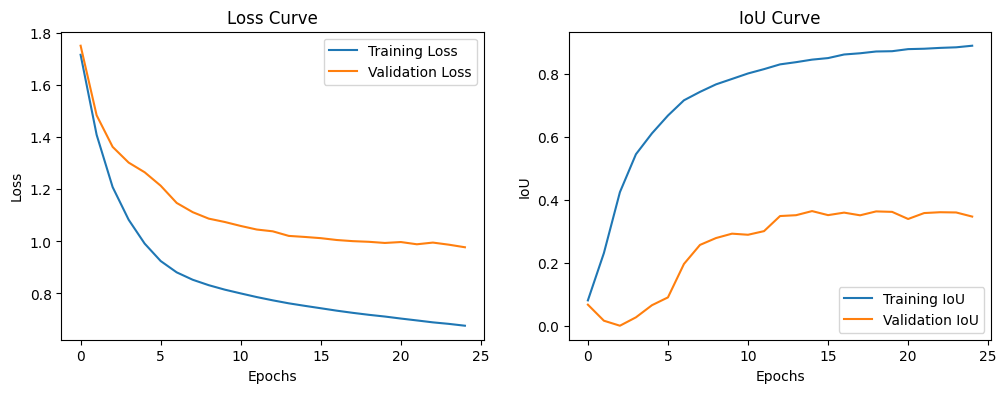

In [ ]:
# Plotting the loss and IoU curves
def plot_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_metric'], label='Training IoU')
    plt.plot(history.history['val_iou_metric'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Curve')
    plt.legend()

    plt.show()

plot_curves(history)

**Find the results**

In [12]:
# Evaluate on the training set
train_iou_scores = model.evaluate(train_dataset, verbose=1)
print(f"Average IoU for the training set: {train_iou_scores[1]:.4f}")

# Evaluate on the validation set
val_iou_scores = model.evaluate(val_dataset, verbose=1)
print(f"Average IoU for the validation set: {val_iou_scores[1]:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - iou_metric: 0.7690 - loss: 0.6053
Average IoU for the training set: 0.7831
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - iou_metric: 0.4147 - loss: 0.8483
Average IoU for the validation set: 0.3591


**Visualize the images and the masks along with the predictions**

In [13]:
# Visualization function
def visualize_predictions(model, dataset, num_images=5):
    for i in range(num_images):
        images, masks = dataset[i]
        predictions = model.predict(images)

        for j in range(len(images)):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            image = images[j]
            mask = masks[j].squeeze()
            prediction = predictions[j].squeeze()

            axes[0].imshow(image)
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            axes[2].imshow(prediction, cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.show()

In [14]:
# Visualize predictions for the training set
print("Visualizing predictions for the training set:")
visualize_predictions(model, train_dataset)

In [ ]:
# Visualize predictions for the validation set
print("Visualizing predictions for the validation set:")
visualize_predictions(model, val_dataset)